<a href="https://colab.research.google.com/github/HaikalHdytullah/Sentiment-Analysis-ChatGPT-Naive-Bayes/blob/main/Sentiment_analysis_label_with_smote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nltk
!pip install Sastrawi
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 8.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import os
import requests
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.patches as mpatches
nltk.download('punkt') #Mengunduh data tokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
#dataset
dataset = "/content/dataset-label.csv"
normalisasi_path = "/content/normalisasi.csv"

In [ ]:
#read & save file to dataframe
df = pd.read_csv(dataset)
df_kamus = pd.read_csv(normalisasi_path)

In [ ]:
#Data Cleansing
def clean_text(text):
  #menghapus huruf berulang
  pattern = re.compile(r"(.)\1{2,}", re.DOTALL)
  text = pattern.sub(r"\1\1", text)
  # Menghapus URL
  url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
  text = re.sub(url_pattern, '', text)
  # Menghapus Hashtag
  hashtag_pattern = re.compile(r'#\w+')
  text = re.sub(hashtag_pattern, '', text)
  # Menghapus emoji, tanda baca, angka dan karakter selain huruf a-z
  text = re.sub(r'[^a-z\s]', ' ', text, flags=re.IGNORECASE)
  return text.strip()
df['Ulasan'] = df['Ulasan'].apply(clean_text)
df.to_csv('preprocess/1. Data-Cleansing.csv', index=False)

In [ ]:
#Case Folding
def case_folding(text):
    text = text.lower()
    return text
df['Ulasan'] = df['Ulasan'].apply(case_folding)
df.to_csv('preprocess/2. Case-Folding.csv', index=False)

In [ ]:
#Tokenizing
def tokenizing(text):
  text = word_tokenize(text)
  return text
df['Ulasan'] = df['Ulasan'].apply(tokenizing)
df.to_csv('preprocess/3. Tokenizing.csv', index=False)

In [ ]:
#Normalize
def normalize(text):
  kamus = {}
  for index, row in df_kamus.iterrows():
    sebelum = row[0]
    sesudah = row[1]
    kamus[sebelum] = sesudah
  text = [kamus.get(token, token) for token in text]
  return text
df['Ulasan'] = df['Ulasan'].apply(normalize)
df.to_csv('preprocess/4. Normalize.csv', index=False)

In [ ]:
#Stopword Removal
def stopword_removal(text):
    factory = StopWordRemoverFactory()
    stopword = factory.create_stop_word_remover()
    text = stopword.remove(' '.join(text))
    text = text.split()
    return text
df['Ulasan'] = df['Ulasan'].apply(stopword_removal)
df.to_csv('preprocess/5. Stopword-Removal.csv', index=False)

In [ ]:
#Stemming
def stemming(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(token) for token in text]
    return text
df['Ulasan'] = df['Ulasan'].apply(stemming)
df.to_csv('preprocess/6. Stemming.csv', index=False)

In [ ]:
def transformation(test_size, smt, info):
    # memuat dataset
    df = pd.read_csv('/content/preprocess/6. Stemming.csv')

    # memisahkan fitur dan label
    x = df['Ulasan']
    y = df['Label']

    # informasi dataset
    n_komentar = len(df.index)
    n_pos = sum(y == 'Positif')
    n_neg = sum(y == 'NEGATIF')

    # membagi dataset menjadi data training dan data testing
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)
    train_data = y_train
    test_data = y_test

    # simpan hasil data training dan testing lalu urutkan berdasarkan index
    df_train = pd.DataFrame({'Ulasan': x_train, 'Label': y_train})
    df_test = pd.DataFrame({'Ulasan': x_test, 'Label': y_test})

    # menghitung jumlah ulasan positif dan negatif pada data testing
    n_pos_test = sum(y_test == 'Positif')
    n_neg_test = sum(y_test == 'Negatif')

    # menghitung jumlah ulasan positif dan negatif pada data training
    n_pos_train = sum(y_train == 'Positif')
    n_neg_train = sum(y_train == 'Negatif')

    # ekstraksi fitur menggunakan tf-idf
    vectorizer = TfidfVectorizer()
    x_train_tfidf = vectorizer.fit_transform(x_train)
    x_test_tfidf = vectorizer.transform(x_test)
    n_feature_tfidf = x_train_tfidf.shape[1]

    # hasil ekstraksi fitur menggunakan tf-idf
    feature_names = vectorizer.get_feature_names_out()
    feature_names = np.sort(feature_names)
    df_tfidf = pd.DataFrame(x_train_tfidf.toarray(), columns=feature_names)
    df_tfidf.to_csv('preprocess/tfidf-{}.csv'.format(test_size), index=False)


    if smt == True and info == True:
      # data sebelum dilakukan oversampling
      print(format(sum(y_train == 'Positif')))
      print(format(sum(y_train == 'Negatif')))

      sm = SMOTE(random_state = 3)
      x_train_res , y_train_res = sm.fit_resample(x_train_tfidf, y_train.ravel())
      train_data_res = y_train_res

      # data setelah dilakukan oversampling
      print(sum(y_train_res == 'Positif'))
      print(sum(y_train_res == 'Negatif'))

      # seleksi fitur dengan menggunakan information gain
      selector = SelectKBest(mutual_info_classif, k='all')
      x_train = selector.fit_transform(x_train_res, y_train_res)
      scores = selector.scores_
      selected_features = scores > 0.001
      x_train = x_train[:, selected_features]
      x_test = x_test_tfidf[:, selected_features]
      n_feature_ig = x_train.shape[1]

      # hasil ekstraksi fitur menggunakan information gain
      feature_names = feature_names[selected_features]
      feature_names = np.sort(feature_names)
      df_ig = pd.DataFrame(x_train.toarray(), columns=feature_names)
      df_ig.to_csv('preprocess/igsmote-{}.csv'.format(test_size), index=False)
      return(train_data, train_data_res, test_data, x_train, x_test, y_train_res, y_test, n_komentar, n_pos, n_neg, n_pos_test, n_neg_test, n_pos_train, n_neg_train, n_feature_tfidf, n_feature_ig, df_train, df_test)
    else:
      return(train_data, test_data, x_train_tfidf, x_test_tfidf, y_train, y_test, n_komentar, n_pos, n_neg, n_pos_test, n_neg_test, n_pos_train, n_neg_train, n_feature_tfidf, df_train, df_test)










In [ ]:
def data_mining(x_train, y_train, x_test, y_test, test_size, df_train, df_test, smt, info):
    # membuat model klasifikasi dengan menggunakan naive bayes
    clf = MultinomialNB()

    # melatih model naive bayes dengan data training
    clf.fit(x_train, y_train)

    # melakukan prediksi model naive bayes terhadap data testing
    y_pred = clf.predict(x_test)

    # mendapatkan prediksi probabilitas untuk setiap kelas
    y_score = clf.predict_proba(x_test)[:,1]

    # Simpan Hasil Klasifikasi dengan Naive Bayes Multinomial kedalam dataframe
    df_test['nb_multinomial'] = y_pred

    # Simpan df_test kedalam file csv
    if smt == True and info == True:
      df_test.to_csv('Data Mining/opt/hasil_klasifikasi_nb_opt_{}.csv'.format(test_size), index=True)
      # Gabungkan dan simpan df_train dan df_test kedalam file csv
      df_train = df_train.append(df_test)
      df_train.to_csv('Data Mining/opt/hasil_dataset_opt_{}.csv'.format(test_size),index=True)
      # bersihin output
      clear_output()

      return(y_pred, y_score)
    else:
      df_test.to_csv('Data Mining/ori/hasil_klasifikasi_ori_{}.csv'.format(test_size), index=True)
      # Gabungkan dan simpan df_train dan df_test kedalam file csv
      df_train = df_train.append(df_test)
      df_train.to_csv('Data Mining/ori/hasil_dataset_ori_{}.csv'.format(test_size),index=True)
      # bersihin output
      clear_output()
      return(y_pred, y_score)





In [ ]:
def evaluation(y_test, y_pred, y_score, n_pos_test, n_neg_test, n_pos_train, n_neg_train):
    # menghitung performa model dengan menggunakan confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tp = cm[1, 1]
    fp = cm[1, 0]
    tn = cm[0, 0]
    fn = cm[0, 1]

    # menghitung metrik evaluasi model
    accuracy = accuracy_score(y_test, y_pred)
    precision_pos = precision_score(y_test, y_pred, pos_label='Positif')
    precision_neg = precision_score(y_test, y_pred, pos_label='Negatif')
    precision_all = (precision_pos + precision_neg) / 2
    recall_pos = recall_score(y_test, y_pred, pos_label='Positif')
    recall_neg = recall_score(y_test, y_pred, pos_label='Negatif')
    recall_all = (recall_pos + recall_neg) / 2
    f1_pos = f1_score(y_test, y_pred, pos_label='Positif')
    f1_neg = f1_score(y_test, y_pred, pos_label='Negatif')
    f1_all = (f1_pos + f1_neg) / 2

    # menghitung jumlah ulasan yang terklasifikasi oleh model
    n_pos = tp + fn + n_pos_train
    n_neg = fp + tn + n_neg_train

    return (tp, fp, tn, fn, accuracy, precision_all, recall_all, f1_all, n_pos, n_neg, y_pred, y_score)

In [ ]:
def evaluate_model(test_size, smt, info):
    # membagi dataset menjadi data training dan data testing sekaligus mentranformasi data
    if smt == True and info == True:
      train_data, train_data_res, test_data, x_train, x_test, y_train, y_test, n_komentar, n_pos, n_neg, n_pos_test, n_neg_test, n_pos_train, n_neg_train, n_feature_tfidf, n_feature_ig, df_train, df_test = transformation(test_size, smt, info)
    else:
      train_data, test_data, x_train, x_test, y_train, y_test, n_komentar, n_pos, n_neg, n_pos_test, n_neg_test, n_pos_train, n_neg_train, n_feature_tfidf, df_train, df_test = transformation(test_size, smt, info)

    # Membuat model Naive Bayes
    y_pred, y_score = data_mining(x_train, y_train, x_test, y_test, test_size, df_train, df_test, smt, info)

    # Evaluasi
    tp, fp, tn, fn, accuracy, precision, recall, f1, n_pos, n_neg, y_pred, y_score = evaluation(y_test, y_pred, y_score, n_pos_test, n_neg_test, n_pos_train, n_neg_train)

    # konversi accuracy, precision, recall dan f1 menjadi persen
    accuracy = accuracy * 100
    precision = precision * 100
    recall = recall * 100
    f1 = f1 * 100

    # menyimpan hasil evaluasi model
    if info == True and smt == True:
        skenario = pd.DataFrame({'train_data': [train_data], 'test_data': [test_data], 'train_data_res': [train_data_res], 'test_size': [test_size], 'SMOTE': [smt], 'InfoGain': [info], 'n_komentar': [n_komentar], 'n_pos': [n_pos], 'n_neg': [n_neg], 'n_pos_test': [n_pos_test], 'n_neg_test': [n_neg_test], 'n_pos_train': [n_pos_train], 'n_neg_train': [n_neg_train], 'n_feature_tfidf': [n_feature_tfidf], 'n_feature_ig': [n_feature_ig], 'tp': [tp], 'fp': [fp], 'tn': [tn], 'fn': [fn], 'accuracy': [accuracy], 'precision': [precision], 'recall': [recall], 'f1': [f1], 'n_pos': [n_pos], 'n_neg': [n_neg], 'y_pred': [y_pred], 'y_test': [y_test]})
    else:
        skenario = pd.DataFrame({'train_data': [train_data], 'test_data': [test_data], 'test_size': [test_size], 'SMOTE': [smt], 'InfoGain': [info], 'n_komentar': [n_komentar], 'n_pos': [n_pos], 'n_neg': [n_neg], 'n_pos_test': [n_pos_test], 'n_neg_test': [n_neg_test], 'n_pos_train': [n_pos_train], 'n_neg_train': [n_neg_train], 'n_feature_tfidf': [n_feature_tfidf], 'tp': [tp], 'fp': [fp], 'tn': [tn], 'fn': [fn], 'accuracy': [accuracy], 'precision': [precision], 'recall': [recall], 'f1': [f1], 'n_pos': [n_pos], 'n_neg': [n_neg], 'y_pred': [y_pred], 'y_test': [y_test]})

    return skenario


In [ ]:
# Model OPT
# Skenario menggunakan infogain dan smote
skenario1_opt = evaluate_model(0.5, True, True)
skenario2_opt = evaluate_model(0.4, True, True)
skenario3_opt = evaluate_model(0.3, True, True)
skenario4_opt = evaluate_model(0.2, True, True)
skenario5_opt = evaluate_model(0.1, True, True)

In [ ]:
# Model ORI
# Skenario tidak menggunakan optimasi
skenario1 = evaluate_model(0.5, False, False)
skenario2 = evaluate_model(0.4, False, False)
skenario3 = evaluate_model(0.3, False, False)
skenario4 = evaluate_model(0.2, False, False)
skenario5 = evaluate_model(0.1, False, False)

<Figure size 1800x500 with 0 Axes>

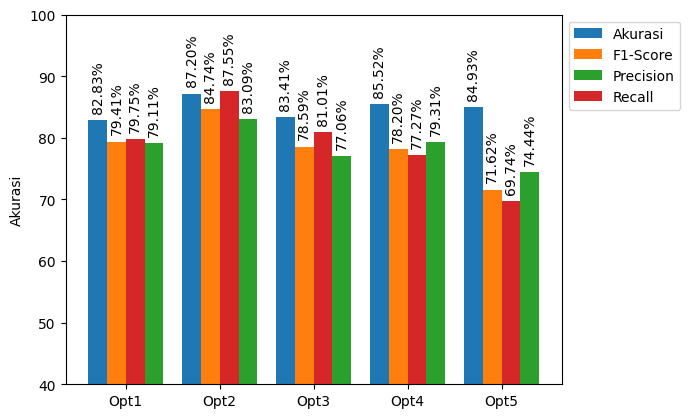

In [ ]:
# Data Akurasi Hasil Penelitian menggunakan SMOTE dan info gain dari 5 skenario
accuracy = [skenario1_opt['accuracy'][0], skenario2_opt['accuracy'][0], skenario3_opt['accuracy'][0], skenario4_opt['accuracy'][0], skenario5_opt['accuracy'][0]]
f1 = [skenario1_opt['f1'][0], skenario2_opt['f1'][0], skenario3_opt['f1'][0], skenario4_opt['f1'][0], skenario5_opt['f1'][0]]
precision = [skenario1_opt['precision'][0], skenario2_opt['precision'][0], skenario3_opt['precision'][0], skenario4_opt['precision'][0], skenario5_opt['precision'][0]]
recall = [skenario1_opt['recall'][0], skenario2_opt['recall'][0], skenario3_opt['recall'][0], skenario4_opt['recall'][0], skenario5_opt['recall'][0]]
labels = ['Opt1', 'Opt2', 'Opt3', 'Opt4', 'Opt5']

x = np.arange(len(labels)) # Label skenario pengujian
width = 0.2 # Lebar bar chart

# Mengatur ukuran gambar
plt.figure(figsize=(18, 5))  # Ukuran gambar adalah 8 inch x 6 inch

fig, ax = plt.subplots()
rects1 = ax.bar(x - width * 1.5, accuracy, width, label='Akurasi')
rects2 = ax.bar(x - width / 2, f1, width, label='F1-Score')
rects3 = ax.bar(x + width * 1.5, precision, width, label='Precision')
rects4 = ax.bar(x + width / 2, recall, width, label='Recall')

# Menambahkan label pada grafik dan fungsi autolabel

# Mengatur batas sumbu y
ax.set_ylabel('Akurasi')
ax.set_ylim([40, 100])

# Menambahkan nilai akurasi dan F1-Score pada setiap bar chart
def autolabel(rects, values, type):
    for rect, value in zip(rects, values):
        height = rect.get_height()
        ax.annotate('{:.2f}%'.format(value),  # menampilkan nilai dengan format persentase
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    rotation=90)  # Rotasi 90 derajat untuk nilai akurasi, presisi, recall, dan F1-Score

autolabel(rects1, accuracy, 0)
autolabel(rects2, f1, 1)
autolabel(rects3, precision, 2)
autolabel(rects4, recall, 3)

# Menuliskan label sumbu x
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))


# Menampilkan grafik
plt.show()


72.29916897506925


<Figure size 1800x500 with 0 Axes>

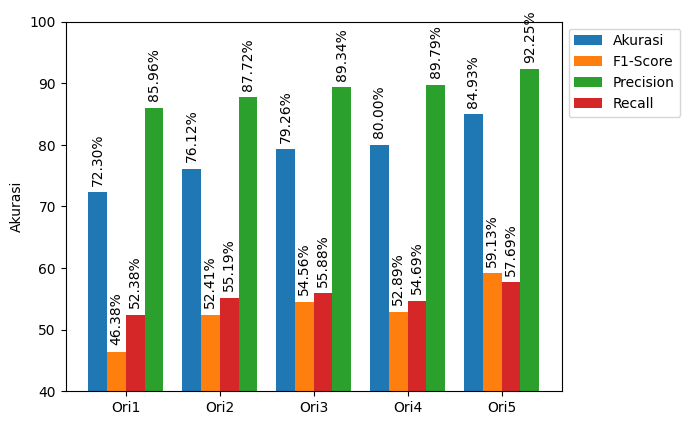

In [ ]:
# Data Akurasi Hasil Penelitian tanpa optimasi dari 5 skenario
accuracy = [skenario1['accuracy'][0], skenario2['accuracy'][0], skenario3['accuracy'][0], skenario4['accuracy'][0], skenario5['accuracy'][0]]
f1 = [skenario1['f1'][0], skenario2['f1'][0], skenario3['f1'][0], skenario4['f1'][0], skenario5['f1'][0]]
precision = [skenario1['precision'][0], skenario2['precision'][0], skenario3['precision'][0], skenario4['precision'][0], skenario5['precision'][0]]
recall = [skenario1['recall'][0], skenario2['recall'][0], skenario3['recall'][0], skenario4['recall'][0], skenario5['recall'][0]]
labels = ['Ori1', 'Ori2', 'Ori3', 'Ori4', 'Ori5']

# Mengatur ukuran gambar
plt.figure(figsize=(18, 5))  # Ukuran gambar adalah 8 inch x 6 inch
x = np.arange(len(labels)) # Label skenario pengujian
width = 0.2 # Lebar bar chart
fig, ax = plt.subplots()
rects1 = ax.bar(x - width*1.5, accuracy, width, label='Akurasi')
rects2 = ax.bar(x - width/2, f1, width, label='F1-Score')
rects3 = ax.bar(x + width*1.5, precision, width, label='Precision')
rects4 = ax.bar(x + width/2, recall, width, label='Recall')

# Menambahkan label pada grafik
ax.set_ylabel('Akurasi')
# ax.set_title('Akurasi pada 5 skenario pengujian')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Menambahkan nilai akurasi dan F1-Score pada setiap bar chart
def autolabel(rects, values):
    for rect, value in zip(rects, values):
        height = rect.get_height()
        ax.annotate('{:.2f}%'.format(value), # menampilkan nilai dengan format persentase
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 5), # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom',
            rotation=90)

autolabel(rects1, accuracy)
autolabel(rects2, f1)
autolabel(rects3, precision)
autolabel(rects4, recall)

ax.set_ylim([40,100])

# Menampilkan grafik
plt.show()


In [ ]:
from matplotlib import pyplot
from collections import Counter

# Visualize the data
unique_labels = np.unique(y_train)
counter = Counter(y_train)

for label, _ in counter.items():
    row_ix = np.where(y_train == label)[0]
    x_values = x_train_tfidf[row_ix].toarray().ravel()
    y_values = x_train_tfidf[row_ix].toarray().ravel()
    pyplot.scatter(x_values, y_values, label=str(label))

pyplot.legend()
pyplot.show()

In [ ]:
!zip -r /content/data mining.zip /content/Data\ Mining
!zip -r /content/preprocess.zip /content/preprocess


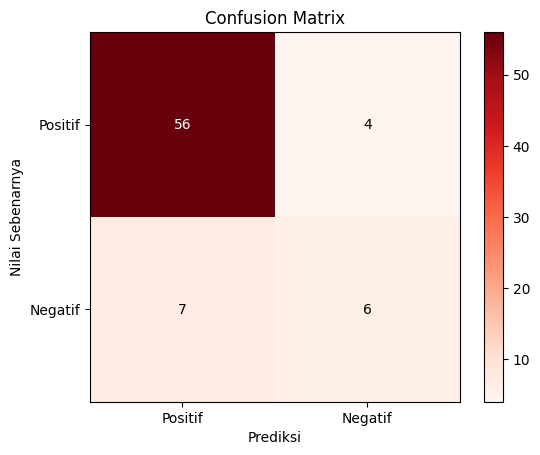

In [ ]:
# Membuat confusion matrix
cm = confusion_matrix(skenario5_opt['y_test'][0].tolist(), skenario5_opt['y_pred'][0], labels=['Positif', 'Negatif'])

# Menampilkan confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Positif', 'Negatif'])
plt.yticks(tick_marks, ['Positif', 'Negatif'])
plt.xlabel('Prediksi')
plt.ylabel('Nilai Sebenarnya')

# Menampilkan nilai di dalam kotak confusion matrix
for i in range(2):
    for j in range(2):
        color = 'black'  # Warna default adalah hitam
        if cm[i, j] > 50:  # Ubah warna menjadi putih jika angka FP atau TP lebih besar dari 100
            color = 'white'
        plt.text(j, i, format(cm[i, j]), ha='center', va='center', color=color)

plt.show()

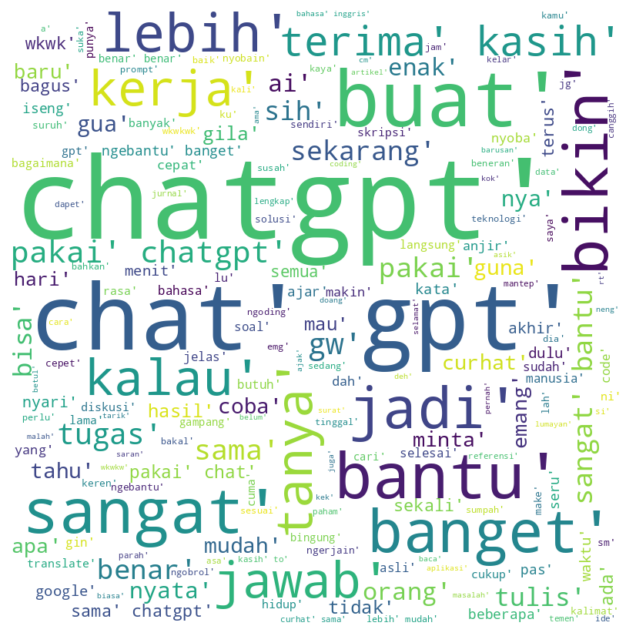

In [ ]:
# memuat dataset
df = pd.read_csv('/content/preprocess/6. Stemming.csv')

# filter hanya ulasan dengan label positif
ulasan_positif = df.loc[df['Label'] == 'Positif', 'Ulasan']
text = ' '.join(ulasan_positif)

# create wordcloud object
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(text)

# plot wordcloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


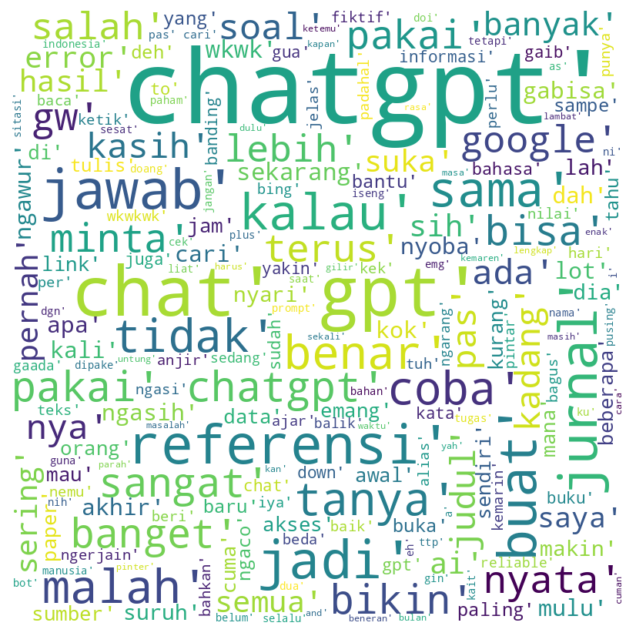

In [ ]:
# memuat dataset
df = pd.read_csv('/content/preprocess/6. Stemming.csv')

# filter hanya ulasan dengan label positif
ulasan_positif = df.loc[df['Label'] == 'Negatif', 'Ulasan']
text = ' '.join(ulasan_positif)

# create wordcloud object
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(text)

# plot wordcloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
